## 이미지 분할 예제

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-07-24 06:27:40--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-07-24 06:27:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-07-24 06:27:40--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [1]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')])


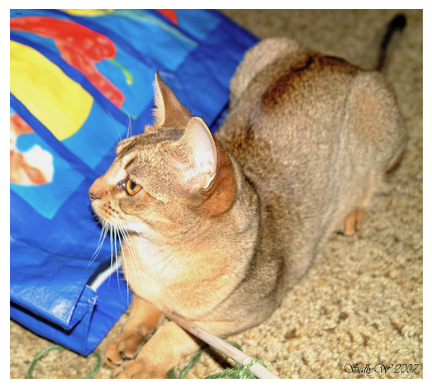

In [2]:
# 입력 시각화
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

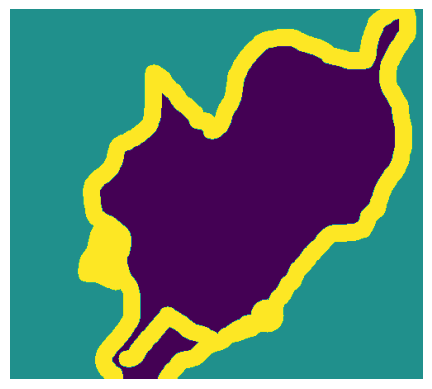

In [3]:
# 분할마스크 시각화
def display_target(target_array):
  normalized_array = (target_array.astype('uint8') - 1) * 127 # 원래 레이블 1, 2, 3을 0, 127, 254로 만듦
  plt.axis('off')
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_img_paths[9], color_mode = 'grayscale'))
display_target(img)

In [4]:
import numpy as np
import random

img_size = (180, 180)
num_imgs = len(input_img_paths)

# 1337은 시드 : 품종별로 정렬되어 있는 파일 경로를 섞는다.
# 섞는 방법이 일치하도록 동일한 시드를 이용한다.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size = img_size, color_mode = 'grayscale')
  )
  img = img.astype('uint8') - 1 # 레이블을 0, 1, 2가 되도록 수정
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = 'float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype = 'uint8')

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_img_paths[i])


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [7]:
# 모델 정의
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape = img_size + (3, ))
  x = layers.Rescaling(1./255)(inputs) # 입력 이미지 0 ~ 1 스케일링 : 필수!
  x = layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)
  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size = img_size, num_classes = 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [9]:
# 모델 컴파일 및 훈련
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only = True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs = 15,
                    callbacks = callbacks,
                    batch_size = 128,
                    validation_data = (val_input_imgs, val_targets))

Epoch 1/15
50/50 [==============================] - 124s 2s/step - loss: 0.9579 - val_loss: 0.9705
Epoch 2/15
50/50 [==============================] - 62s 1s/step - loss: 0.9253 - val_loss: 0.8834
Epoch 3/15
50/50 [==============================] - 60s 1s/step - loss: 0.8840 - val_loss: 0.8485
Epoch 4/15
50/50 [==============================] - 60s 1s/step - loss: 0.8608 - val_loss: 0.8442
Epoch 5/15
50/50 [==============================] - 60s 1s/step - loss: 0.8768 - val_loss: 0.8384
Epoch 6/15
50/50 [==============================] - 62s 1s/step - loss: 0.8367 - val_loss: 0.8732
Epoch 7/15
50/50 [==============================] - 62s 1s/step - loss: 0.8272 - val_loss: 0.8763
Epoch 8/15
50/50 [==============================] - 62s 1s/step - loss: 0.8208 - val_loss: 0.8034
Epoch 9/15
50/50 [==============================] - 60s 1s/step - loss: 0.7853 - val_loss: 0.8127
Epoch 10/15
50/50 [==============================] - 62s 1s/step - loss: 0.7640 - val_loss: 0.7541
Epoch 11/15
50/50 

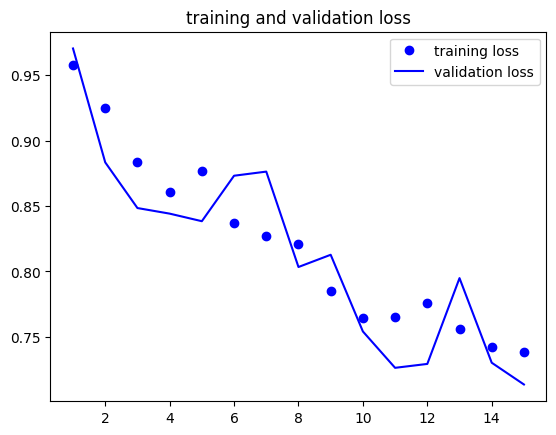

In [12]:
# 훈련, 검증 손실 시각화
def visualize(history):
  epochs = range(1, len(history.history['loss'])+1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure()
  plt.plot(epochs, loss, 'bo', label = 'training loss')
  plt.plot(epochs, val_loss, 'b', label = 'validation loss')
  plt.title("training and validation loss")
  plt.legend()

visualize(history)

1/1 [==============================] - 0s 195ms/step


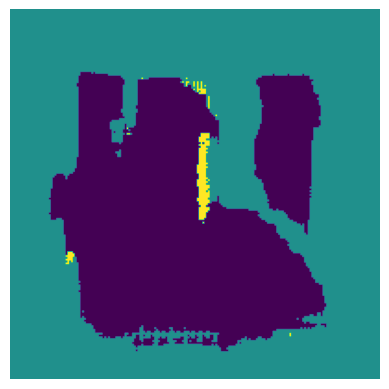

In [16]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('oxford_segmentation.keras')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
  mask = np.argmax(pred, axis = -1)
  mask *= 127
  plt.axis('off')
  plt.imshow(mask)

display_mask(mask)

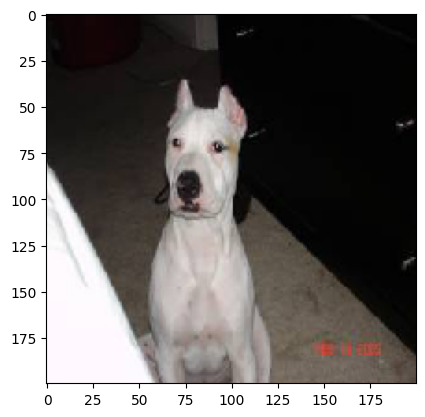

In [17]:
plt.imshow(array_to_img(test_image))

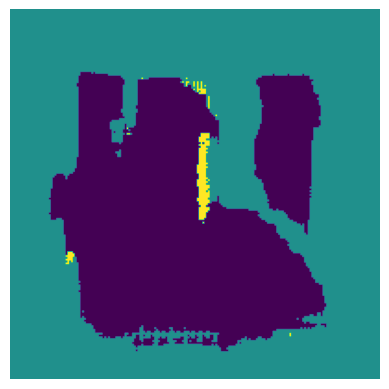

In [18]:
display_mask(mask)

### 잔차 연결

In [22]:
inputs= keras.Input(shape = (32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling = False):
	residual = x
	x = layers.Conv2D(filters, 3, activation = 'relu', padding = 'same')(x)
	x = layers.Conv2D(filters, 3, activation = 'relu', padding = 'same')(x)

	if pooling:
		x = layers.MaxPooling2D(2, padding = 'same')(x)
		residual = layers.Conv2D(filters, 1, strides = 2)(residual) # 1.
	elif filters != residual.shape[-1]:
		residual = layers.Conv2D(filters, 1)(residual)
	x = layers.add([x, residual])

	return x

x = residual_block(x, filters = 32, pooling = True)
x = residual_block(x, filters = 64, pooling = True)
x = residual_block(x, filters = 128, pooling = False) # 바로 전역 평균 풀링을 쓰므로 최대풀링 사용 x

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_4[0][0]']            
                                                                                                  
 conv2d_35 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_34[0][0]']              
                                                                                            

## Xception 유사 모델에 적용하기
- 8장의 강아지 고양이 이진 분류 예제에 적용함
- 런타임 초기화하고 실행하는 거 추천

In [18]:
# kaggle.json 업로드
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hyeontaelee","key":"3dd96eee16e99d6dba90709b3153bd52"}'}

In [6]:
# 경로 잘 확인하고 입력
!cp kaggle.json ~/.kaggle/
!chmod 600 kaggle.json

# 데이터 다운로드
! kaggle competitions download -c dogs-vs-cats
# 403 forbidden이 뜬 경우 www.kaggle.com/c/dogs-vs-cats/rules 에서 약관 동의 눌러주자

# 압축 해제
!unzip --qq dogs-vs-cats.zip
!unzip -qq train.zip

... resuming from 380633088 bytes (470943601 bytes left) ...
 99% 808M/812M [00:11<00:00, 38.8MB/s]
100% 812M/812M [00:12<00:00, 39.1MB/s]


In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ('cat', 'dog'):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# 특성 채널은 독립적이다 라는 가정은 RGB이미지에는 맞지 않다!
# 그래서 모델의 1번째 층은 일반적인 Conv2D로 시작한다. 이후 채널은 RGB로 이뤄지지 않기 때문.
x = layers.Conv2D(filters = 32, kernel_size = 5, use_bias = False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(size, 3, padding = 'same', use_bias = False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(size, 3, padding = 'same', use_bias = False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding = 'same')(x)

  residual = layers.Conv2D(size, 1, strides = 2, padding = 'same', use_bias = False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.summary()

In [17]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only = True)
]

history = model.fit(train_dataset,
                    epochs = 30,
                    callbacks = callbacks,
                    batch_size = 64,
                    validation_data = validation_dataset)

Epoch 1/30
63/63 [==============================] - 19s 150ms/step - loss: 0.4647 - accuracy: 0.7895 - val_loss: 1.4483 - val_accuracy: 0.5580
Epoch 2/30
63/63 [==============================] - 11s 160ms/step - loss: 0.4606 - accuracy: 0.7935 - val_loss: 1.1484 - val_accuracy: 0.6750
Epoch 3/30
63/63 [==============================] - 11s 164ms/step - loss: 0.4577 - accuracy: 0.8025 - val_loss: 1.2900 - val_accuracy: 0.5160
Epoch 4/30
63/63 [==============================] - 10s 156ms/step - loss: 0.4161 - accuracy: 0.8195 - val_loss: 0.7172 - val_accuracy: 0.6620
Epoch 5/30
63/63 [==============================] - 9s 141ms/step - loss: 0.4243 - accuracy: 0.8135 - val_loss: 0.4742 - val_accuracy: 0.7700
Epoch 6/30
63/63 [==============================] - 10s 145ms/step - loss: 0.4074 - accuracy: 0.8190 - val_loss: 0.5336 - val_accuracy: 0.7710
Epoch 7/30
63/63 [==============================] - 9s 145ms/step - loss: 0.3924 - accuracy: 0.8225 - val_loss: 0.4849 - val_accuracy: 0.7690
E

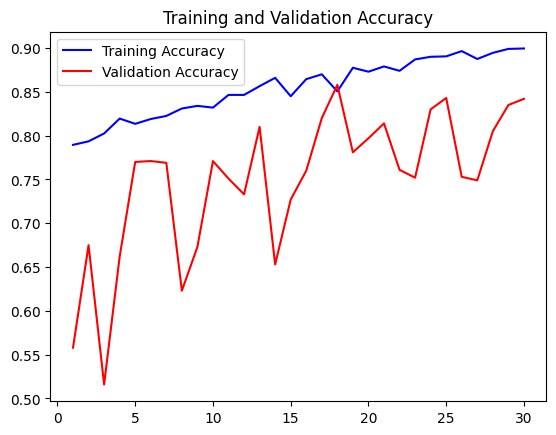

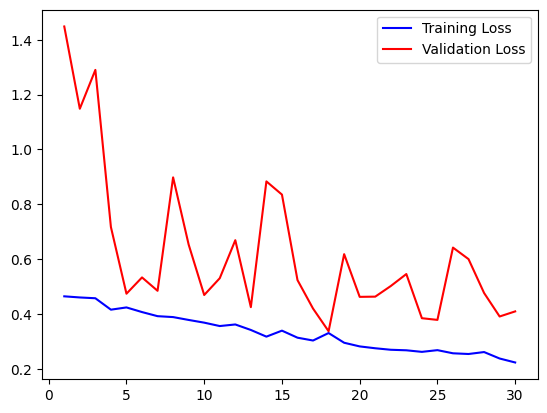

In [22]:
def visualize(history):
  accuracy = history.history['accuracy']
  val_accuracy =history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)

  plt.plot(epochs, accuracy, "b-", label = "Training Accuracy")
  plt.plot(epochs, val_accuracy, "r-", label = "Validation Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, "b-", label = "Training Loss")
  plt.plot(epochs, val_loss, "r-", label = "Validation Loss")
  plt.legend()
  plt.show()

visualize(history)

### 중간 활성화 시각화

In [24]:
# 8-2의 모델을 불러온단다.. 여긴 코랩이라 날라갔음.
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)
model.compile(loss = 'binary_crossentropy',
                optimizer = 'rmsprop',
                metrics = ['accuracy'])

callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath = "convnet_from_scratch_with_augmentation.keras",
  save_best_only = True,
  monitor = 'val_loss'
  )
]

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks= callbacks
)

Epoch 1/100
63/63 [==============================] - 9s 108ms/step - loss: 0.7133 - accuracy: 0.5055 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6935 - accuracy: 0.5315 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 9s 131ms/step - loss: 0.6993 - accuracy: 0.5295 - val_loss: 0.6903 - val_accuracy: 0.5050
Epoch 4/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6857 - accuracy: 0.5625 - val_loss: 0.6654 - val_accuracy: 0.5980
Epoch 5/100
63/63 [==============================] - 8s 114ms/step - loss: 0.6847 - accuracy: 0.5780 - val_loss: 0.7022 - val_accuracy: 0.5090
Epoch 6/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6691 - accuracy: 0.6015 - val_loss: 0.6501 - val_accuracy: 0.6000
Epoch 7/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6635 - accuracy: 0.6145 - val_loss: 0.6633 - val_accuracy: 0.5430
Epo

In [25]:
model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [27]:
import numpy as np

# 훈련에 쓰이지 않은 이미지 하나를 입력으로 선택
img_path = keras.utils.get_file(
    fname = 'cat.jpg',
    origin = 'https://img-datasets.s3.amazonaws.com/cat.jpg'
)

def get_img_array(img_path, target_size):

  # 이미지 로드 & 크기 변경
  img = keras.utils.load_img(
      img_path, target_size = target_size
  )

  # 배열 크기 & 타입 변환
  array = keras.utils.img_to_array(img)

  # 배열을 단일 이미지의 배치로 변환 -> 차원 추가
  array = np.expand_dims(array, axis = 0)
  return array

img_tensor = get_img_array(img_path, target_size = (180, 180))

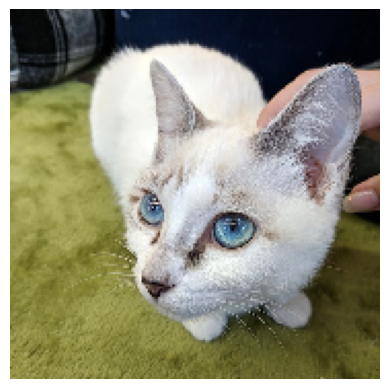

In [28]:
# 이미지 출력
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [45]:
# 특성맵 추출하기

layer_outputs = []
layer_names = []

for layer in model.layers:

  # 모든 Conv2D와 MaxPooling2D 층의 출력을 하나의 리스트에 추가한다.
  # isinstance(a, b) : a가 b타입에 속하면 True
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)

# 입력이 주어졌을 때 출력을 반환하는 모델 생성
activation_model = keras.Model(inputs = model.input,
                               outputs = layer_outputs)

In [46]:
# 층 활성화 계산
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 306ms/step


In [47]:
# 층 활성화 시각화
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


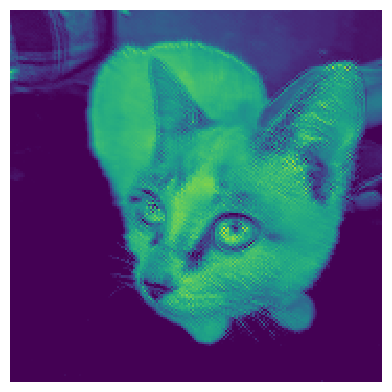

In [54]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 2], cmap = 'viridis')
plt.axis('off')
plt.show()

In [60]:
# 모든 활성화 시각화하기
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(((size + 1) * n_cols - 1,
                           images_per_row * (size + 1) - 1))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy() # 각 채널(특성) 이미지
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128

      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * (size + 1): (col + 1) * size + col,
          row * (size + 1): (row + 1) * size + row
      ] = channel_image # 빈 그리드에 채널행렬 저장

  scale = 1. / size
  plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

Output hidden; open in https://colab.research.google.com to view.

### 컨브넷 필터 시각화하기

In [61]:
model = keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top = False
)

83683744/83683744 [==============================] - 3s 0us/step


In [62]:
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_16
block3_sepconv1
block3_sepconv2
conv2d_17
block4_sepconv1
block4_sepconv2
conv2d_18
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_19
block14_sepconv1
block14_sepconv2


In [65]:
# 특성 추출 모델 만들기
# 한 층의 output을 추출해서 새 모델에 재사용할 수 있다.

layer_name = "block3_sepconv1"
layer = model.get_layer(name = layer_name)
feature_extractor = keras.Model(inputs = model.input, outputs = model.output)

activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [66]:
# 입력 이미지가 층의 필터를 얼마나 활성화하는지를 정량화된 스칼라 값으로 반환함
# 즉 이게 손실함수 역할
def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [75]:
import tensorflow as tf

# 경사 상승법 : 그래디언트 텐서를 L2 놂으로 나눠 정규화하기.
# 이미지에 할당할 수정할 양을 일정 범위 내에 놓을 수 있다.

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image) # 이미지 텐서는 텐서플로우 변수가 아니라 명시적으로 지정한다.
    loss = compute_loss(image, filter_index) # 필터 활성화 : 스칼라 손실 계산
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads) # 그래디언트 정규화 트릭
  image += learning_rate * grads
  return image



In [76]:
# 층 이름, 필터 인덱스를 인풋으로 받아 지정 필터의 활성화를 최대화하는 패턴 텐서를 반환하는 함수
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
  iterations = 30
  learning_rate = 10.

  # 초기화
  image = tf.random.uniform(
      minval = 0.4,
      maxval = 0.6,
      shape = (1, img_width, img_height, 3)
  )

  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)

  return image[0].numpy()

In [77]:
# 텐서 -> 이미지 변환 유틸리티 함수
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128

  image = np.clip(image, 0, 255).astype('uint8')
  image = image[25:-25, 25:-25, :]
  return image


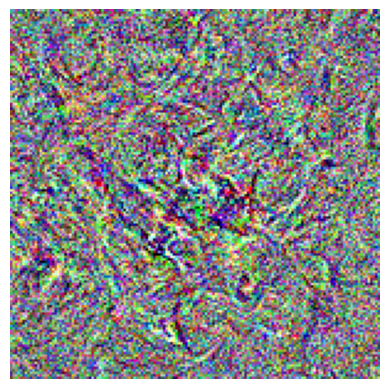

In [78]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index = 2)))
plt.show()

In [81]:
layer_names = ['block2_sepconv1', 'block6_sepconv2', 'block13_sepconv1']

for layer_name in layer_names:
  all_images = []
  for filter_index in range(64):
    print(f"{filter_index}번 필터 처리")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

  margin = 5
  n = 8
  cropped_width = img_width - 25 * 2
  cropped_height = img_height - 25 * 2
  width = n * cropped_width + (n - 1) * margin
  height = n * cropped_height + (n - 1) * margin
  stitched_filters = np.zeros((width, height, 3))

  for i in range(n):
    for j in range(n):
      image = all_images[i * n + j]
      stitched_filters[
          (cropped_width + margin) * i : (cropped_width + margin)* i + cropped_width,
          (cropped_height + margin) * j : (cropped_height + margin) * j + cropped_height,
          :,
      ] = image

  keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

0번 필터 처리
1번 필터 처리
2번 필터 처리
3번 필터 처리
4번 필터 처리
5번 필터 처리
6번 필터 처리
7번 필터 처리
8번 필터 처리
9번 필터 처리
10번 필터 처리
11번 필터 처리
12번 필터 처리
13번 필터 처리
14번 필터 처리
15번 필터 처리
16번 필터 처리
17번 필터 처리
18번 필터 처리
19번 필터 처리
20번 필터 처리
21번 필터 처리
22번 필터 처리
23번 필터 처리
24번 필터 처리
25번 필터 처리
26번 필터 처리
27번 필터 처리
28번 필터 처리
29번 필터 처리
30번 필터 처리
31번 필터 처리
32번 필터 처리
33번 필터 처리
34번 필터 처리
35번 필터 처리
36번 필터 처리
37번 필터 처리
38번 필터 처리
39번 필터 처리
40번 필터 처리
41번 필터 처리
42번 필터 처리
43번 필터 처리
44번 필터 처리
45번 필터 처리
46번 필터 처리
47번 필터 처리
48번 필터 처리
49번 필터 처리
50번 필터 처리
51번 필터 처리
52번 필터 처리
53번 필터 처리
54번 필터 처리
55번 필터 처리
56번 필터 처리
57번 필터 처리
58번 필터 처리
59번 필터 처리
60번 필터 처리
61번 필터 처리
62번 필터 처리
63번 필터 처리
0번 필터 처리
1번 필터 처리
2번 필터 처리
3번 필터 처리
4번 필터 처리
5번 필터 처리
6번 필터 처리
7번 필터 처리
8번 필터 처리
9번 필터 처리
10번 필터 처리
11번 필터 처리
12번 필터 처리
13번 필터 처리
14번 필터 처리
15번 필터 처리
16번 필터 처리
17번 필터 처리
18번 필터 처리
19번 필터 처리
20번 필터 처리
21번 필터 처리
22번 필터 처리
23번 필터 처리
24번 필터 처리
25번 필터 처리
26번 필터 처리
27번 필터 처리
28번 필터 처리
29번 필터 처리
30번 필터 처리
31번 필터 처리
32번 필터 처리
33번 필터 처리
34번 필터 처리
35번 필터 처리
36번 필터 처리
37번 필터 처리


### 클래스 활성화 히트맵 시각화

In [83]:
model = keras.applications.xception.Xception(weights = 'imagenet') # 최상위 밀집 연결층 포함

91884032/91884032 [==============================] - 3s 0us/step


In [84]:
# Xception 모델에 맞게 이미지 전처리
img_path = keras.utils.get_file(
    fname = "elephant.jpg",
    origin = "https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size = target_size)
  array = keras.utils.img_to_array(img) # 299, 299, 3 / float32
  array = np.expand_dims(array, axis = 0) # 1, 299, 299, 3
  array = keras.applications.xception.preprocess_input(array)
  return array

img_array = get_img_array(img_path, target_size = (299, 299))

733657/733657 [==============================] - 0s 1us/step


In [85]:
# 사전 훈련 네트워크 실행 & 예측 벡터 디코딩
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top = 3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699266), ('n01871265', 'tusker', 0.07696868), ('n02504013', 'Indian_elephant', 0.023537282)]


In [86]:
np.argmax(preds[0]) # 아프리카 코끼리 인덱스

386

In [88]:
# Grad-CAM 처리 구현
# 이미지에서 아프리카 코끼리와 같은 부위 시각화

# 마지막 합성곱층 반환하는 모델
last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = [
    'avg_pool',
    'predictions'
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

# 마지막 합성곱층 활성화 -> 최종 클래스 예측 매핑 모델
classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

# 마지막 합성곱 층 활성화에 대한, 최상위 예측클래스의 그래디언트

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [89]:
# 그래디언트 평균 & 중요도 가중치 적용 : 클래스 활성화 히트맵
pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis = -1)

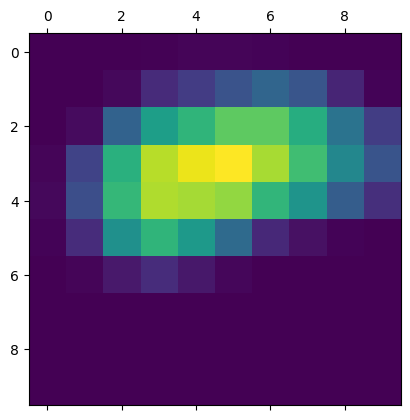

In [90]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [91]:
# 히트맵과 원본 그림을 겹친 이미지

import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

# 색 변경
jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)

<ipython-input-91-25bcd74eff98>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')
